In [111]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerRegularPolyCollection # for legend change color
# from matplotlib import rcParams, matplotlib_fname
# # set the font to support Chinese characters
# rcParams['font.sans-serif'] = ['SimHei']
# # set the font size
# rcParams['font.size'] = 12
# # avoid using unicode minus sign
# rcParams['axes.unicode_minus'] = False

import seaborn as sns
import os
import sys

# 获取当前文件所在的文件夹路径
if "__file__" in globals():
    # 获取__file__变量的值
    file_path = __file__
    # 获取当前文件所在的文件夹路径
    dir_now = os.path.dirname(file_path)
else:
    # 获取当前工作目录
    dir_now = os.getcwd()
sys.path.append(os.path.join(dir_now, '../../'))
sys.path.append(os.path.join(dir_now, '../'))

from NNutils import *
from amm_methods import *

colors_list = ['#F27970', '#BB9727', '#54B345', '#32B897', '#05B9E2',
              '#8983BF', '#C76DA2', '#FFBE7A', '#82B0D2', '#BEB8DC',
              '#E7DAD2', '#999999']
cmap_list = ['Blues', 'Reds', 'Greens', 'Purples', 'Oranges']
cmap_max_list = [(0.05636293733179547, 0.34963475586312953, 0.6367550941945406, 1.0), 
                 (0.4725720876585929, 0.016608996539792385, 0.059838523644752006, 1.0), 
                 (0.034986543637062675, 0.45743944636678197, 0.19753940792003075, 1.0), 
                 (0.2703114186851211, 0.043183391003460206, 0.5101268742791234, 1.0), 
                 (0.5412226066897348, 0.16955017301038064, 0.014579008073817762, 1.0)]


## 统计训练、测试集分布

In [22]:
linear_name = 'etl2'
feedback_bits = 256
linear_name_full = "ex_linear2"
method = METHOD_MITHRAL
ncodebooks = 256 # max:512
ncentroids = [16,32,64,128,256]
train_sam_num = 1000 # 训练集样本数
test_sam_num = 1000


In [23]:
AMM_train_dirs = get_AMM_train_dirs(linear_name, linear_name_full, method, feedback_bits, train_sam_num, test_sam_num)
AMM_train_dirs_train_num_75 = get_AMM_train_dirs(linear_name, linear_name_full, method, feedback_bits, 75, test_sam_num)
train_data = np.load(os.path.join(AMM_train_dirs["dir_train"],AMM_train_dirs["linearin_path_train"]))
train_data_75 = np.load(os.path.join(AMM_train_dirs_train_num_75["dir_train"],AMM_train_dirs_train_num_75["linearin_path_train"]))
test_data = np.load(os.path.join(AMM_train_dirs["dir_test"],AMM_train_dirs["linearin_path_test"]))

In [24]:
D = train_data.shape[1]
DC = int(D / ncodebooks)
i_cb = 0
train_data_n_cb = train_data[:,i_cb*DC:(i_cb+1)*DC] # 取1000batch训练集第n个codebook的数据
train_data_n_cb_col0 = train_data_n_cb[:,0] # 取1000batch训练集第n个codebook的第0列数据
train_data_n_cb_col1 = train_data_n_cb[:,1] # 取1000batch训练集第n个codebook的第1列数据
train_data_75_n_cb = train_data_75[:,i_cb*DC:(i_cb+1)*DC] # 取75batch训练集第n个codebook的数据
train_data_75_n_cb_col0 = train_data_75_n_cb[:,0] # 取75batch训练集第n个codebook的第0列数据
train_data_75_n_cb_col1 = train_data_75_n_cb[:,1] # 取75batch训练集第n个codebook的第1列数据
test_data_n_cb = test_data[:,i_cb*DC:(i_cb+1)*DC] # 取1000batch测试集第n个codebook的数据
test_data_n_cb_col0 = test_data_n_cb[:,0] # 取1000batch测试集第n个codebook的第0列数据
test_data_n_cb_col1 = test_data_n_cb[:,1] # 取1000batch测试集第n个codebook的第1列数据

In [74]:
def plot_dist_remove0(data, bins, data2=None, data3=None, legend=[], title="", save_fig=False):
    '''
    Plot the distribution of the matrix elements after removing zeros
    
    Args:
        data: the matrix to be plotted
        bins: the number of bins
        legend: the legend of the plot
        
    Returns:
        None
        
    Example:
        plot_dist_remove0(np.random.randn(1000, 1000), 100, "random normal")
    '''
    if type(data2) != np.ndarray:
        data = data.flatten()
        # get the max and min values
        max_value = data.max()
        min_value = data.min()
        # create a boolean mask by comparing with zero
        mask = data != 0
        # count the number of zero elements
        zero_count = np.count_nonzero(~mask)
        # calculate the proportion of zeros
        zero_prop = zero_count / mask.size
        # apply the mask to filter out zero elements
        data_no0 = data[mask]
        # plot a histogram of the matrix elements
        plt.hist(data_no0.flatten(), bins=bins, range=(min_value, max_value), label=legend[0], color=colors_list[3])
        plt.legend()
        title = "Distribution of non-zero numbers(original data zero proportion %.2f%%)" % (zero_prop*100)
        plt.title(title)
        plt.xlabel("Value")
        plt.ylabel("Frequency")
        if save_fig:
            plt.savefig("./fig/%s.png" % title)
        plt.show()
    elif type(data2) == np.ndarray and type(data3) != np.ndarray:
        data = data.flatten()
        data2 = data2.flatten()
        # get the max and min values
        max_value = max(data.max(), data2.max())
        min_value = min(data.min(), data2.min())
        # create a boolean mask by comparing with zero
        mask = data != 0
        mask2 = data2 != 0
        # count the number of zero elements
        zero_count = np.count_nonzero(~mask)
        zero_count2 = np.count_nonzero(~mask2)
        # calculate the proportion of zeros
        zero_prop = zero_count / mask.size
        zero_prop2 = zero_count2 / mask2.size
        # apply the mask to filter out zero elements
        data_no0 = data[mask]
        data2_no0 = data2[mask2]
        # plot a histogram of the matrix elements
        plt.hist(data_no0.flatten(), bins=bins, range=(min_value, max_value), label=legend[0], color=colors_list[4], alpha=0.5)
        plt.hist(data2_no0.flatten(), bins=bins, range=(min_value, max_value), label=legend[1], color=colors_list[0], alpha=0.5)
        plt.legend()
        title = "Distribution of non-zero numbers in %s\n(original data zero proportion %.2f%%, %.2f%%)" % (title, zero_prop*100, zero_prop2*100)
        plt.title(title)
        plt.xlabel("Value")
        plt.ylabel("Frequency")
        if save_fig:
            plt.savefig("./fig/%s.png" % title)
        plt.show()
    elif type(data2) == np.ndarray and type(data3) == np.ndarray:
        data = data.flatten()
        data2 = data2.flatten()
        data3 = data3.flatten()
        # get the max and min values
        max_value = max(data.max(), data2.max(), data3.max())
        min_value = min(data.min(), data2.min(), data3.min())
        # create a boolean mask by comparing with zero
        mask = data != 0
        mask2 = data2 != 0
        mask3 = data3 != 0
        # count the number of zero elements
        zero_count = np.count_nonzero(~mask)
        zero_count2 = np.count_nonzero(~mask2)
        zero_count3 = np.count_nonzero(~mask3)
        # calculate the proportion of zeros
        zero_prop = zero_count / mask.size
        zero_prop2 = zero_count2 / mask2.size
        zero_prop3 = zero_count3 / mask3.size
        # apply the mask to filter out zero elements
        data_no0 = data[mask]
        data2_no0 = data2[mask2]
        data3_no0 = data3[mask3]
        # Draw three vertical subplots
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(5, 5))
        title = "Distribution of non-zero numbers in %s\n(original data zero proportion %.2f%%, %.2f%%, %.2f%%)" % (title, zero_prop*100, zero_prop2*100, zero_prop3*100)
        fig.suptitle(title)
        # plot a histogram of the matrix elements
        ax1.hist(data_no0.flatten(), bins=bins, range=(min_value, max_value), label=legend[0], color=colors_list[0])
        # ax1.hist(data_no0.flatten(), bins=bins, range=(min_value, max_value), label=legend[0])
        ax1.legend()
        ax1.set_ylabel("Frequency")
        # plot a histogram of the matrix elements
        ax2.hist(data2_no0.flatten(), bins=bins, range=(min_value, max_value), label=legend[1], color=colors_list[1])
        ax2.legend()
        ax2.set_ylabel("Frequency")
        # plot a histogram of the matrix elements
        ax3.hist(data3_no0.flatten(), bins=bins, range=(min_value, max_value), label=legend[2], color=colors_list[2])
        ax3.legend()
        ax3.set_xlabel("Value")
        ax3.set_ylabel("Frequency")
        if save_fig:
            plt.savefig("./fig/%s.png" % title)
        plt.show()

### 训练集

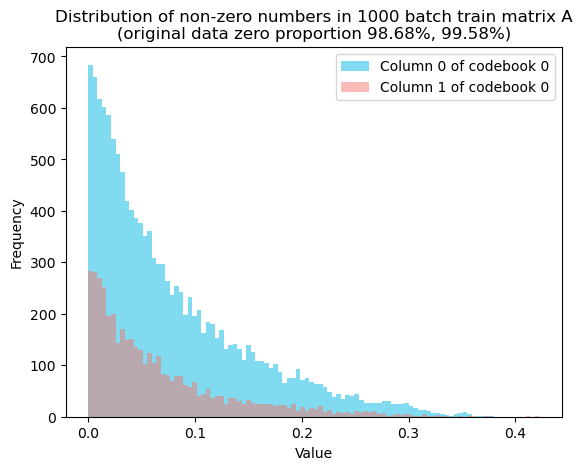

In [75]:
# 绘制1000batch训练集第i_cb个codebook的第0、1列数据的分布
plot_dist_remove0(train_data_n_cb_col0, 100, data2=train_data_n_cb_col1, title="%i batch train matrix A" % train_sam_num, 
                  legend=["Column %d of codebook %d" % (0, i_cb), "Column %d of codebook %d" % (1, i_cb)])

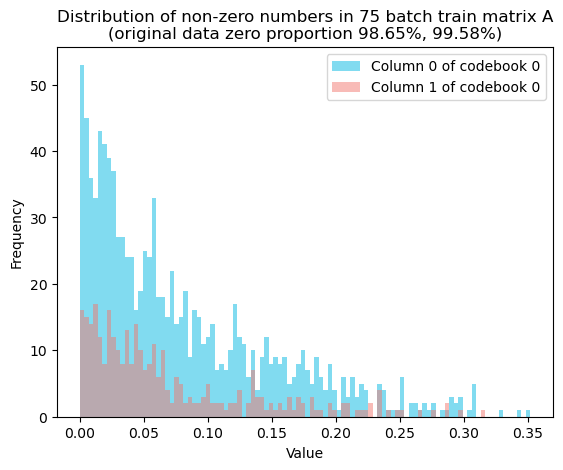

In [76]:
# 绘制75batch训练集第i_cb个codebook的第0、1列数据的分布
plot_dist_remove0(train_data_75_n_cb_col0, 100, data2=train_data_75_n_cb_col1, title="%i batch train matrix A" % 75,
                    legend=["Column %d of codebook %d" % (0, i_cb), "Column %d of codebook %d" % (1, i_cb)])

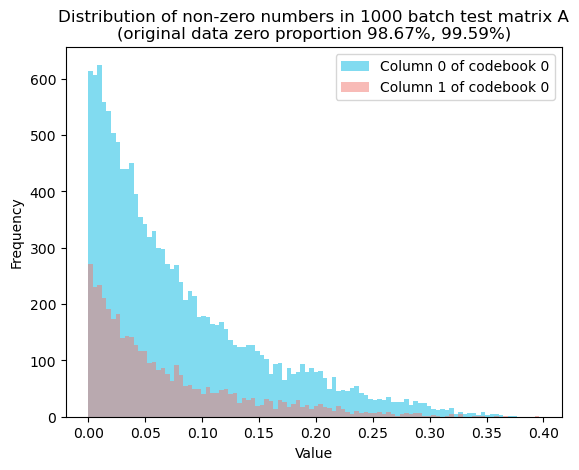

In [77]:
# 绘制1000batch测试集第i_cb个codebook的第0、1列数据的分布
plot_dist_remove0(test_data_n_cb_col0, 100, data2=test_data_n_cb_col1, title="%i batch test matrix A" % test_sam_num,
                    legend=["Column %d of codebook %d" % (0, i_cb), "Column %d of codebook %d" % (1, i_cb)])

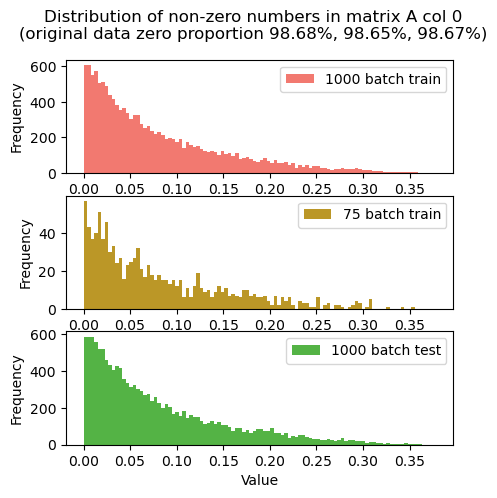

In [55]:
# 绘制1000batch训练集和75batch训练集和1000batch测试集的第i_cb个codebook的第0列数据的分布比较
plot_dist_remove0(train_data_n_cb_col0, 100, data2=train_data_75_n_cb_col0, data3=test_data_n_cb_col0,
                    title="matrix A col 0", legend=["%i batch train" % train_sam_num,
                    "%i batch train" % 75, "%i batch test" % test_sam_num])

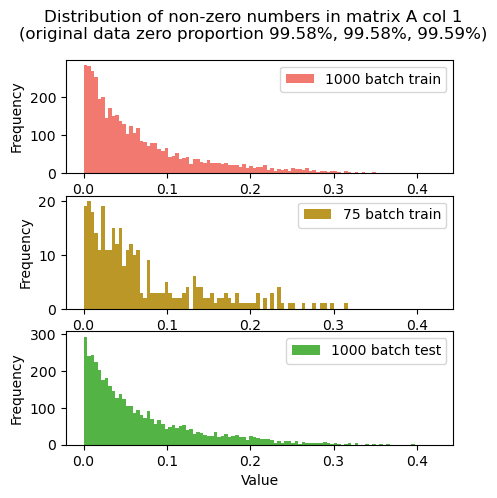

In [78]:
# 绘制1000batch训练集和75batch训练集和1000batch测试集的第i_cb个codebook的第1列数据的分布比较
plot_dist_remove0(train_data_n_cb_col1, 100, data2=train_data_75_n_cb_col1, data3=test_data_n_cb_col1,
                    title="matrix A col 1", legend=["%i batch train" % train_sam_num,
                    "%i batch train" % 75, "%i batch test" % test_sam_num])

## 统计质心

In [118]:
def np_zero_proportion(data):
    '''计算numpy数组的零值占比'''
    # count the number of nonzero elements
    nonzero_count = np.count_nonzero(data)
    # calculate the proportion of zeros
    zero_prop = 1 - nonzero_count / data.size
    return zero_prop


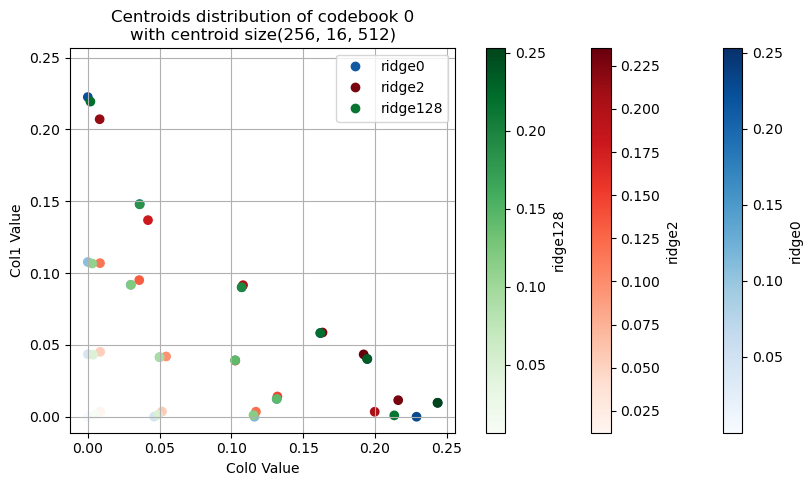

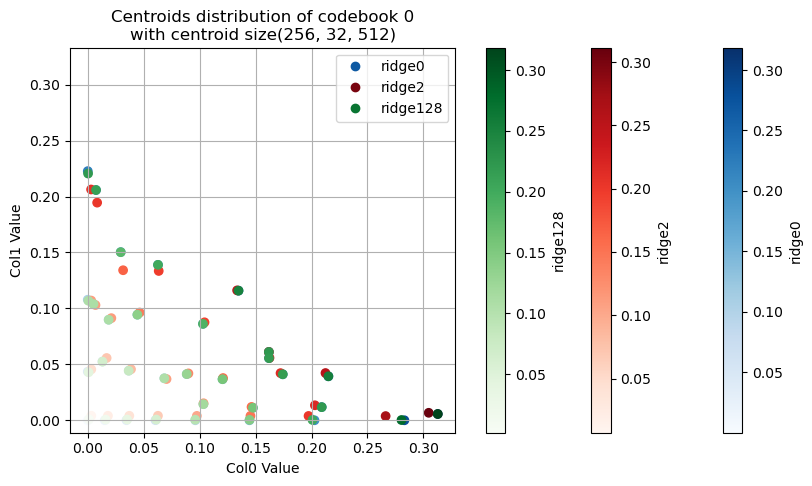

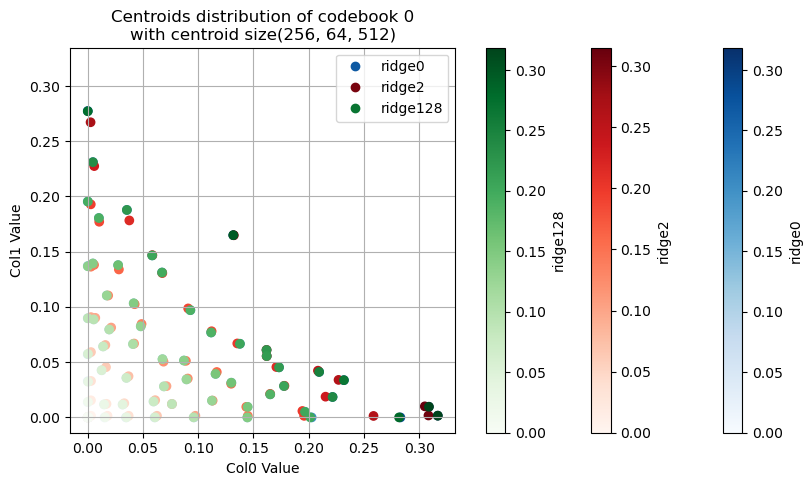

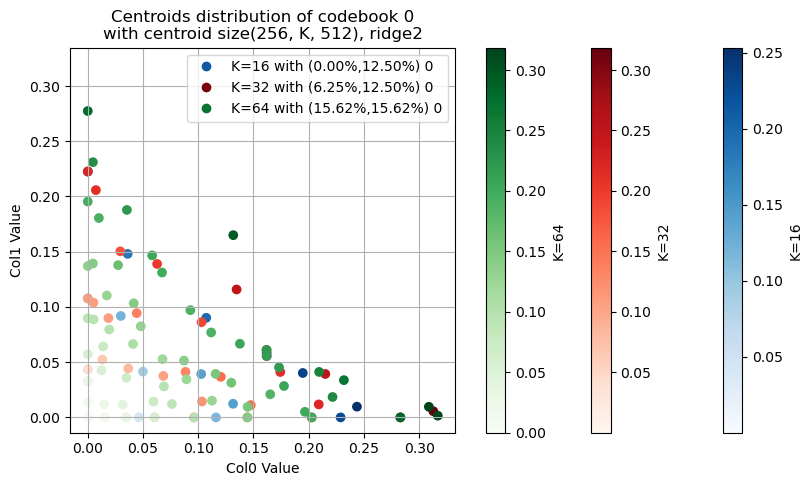

In [124]:
def centroids_distribution_stat(ncodebooks, ncentroids, D, i_cb, step_list, fixed_ridge=2, save_fig=False):
    '''
    绘制不同ridge、不同质心数的质心分布统计图

    Args:
        ncodebooks: 码本数
        ncentroids: 质心数列表
        D: A矩阵列数
        i_cb: 第i_cb个码本
        step_list: ridge的step数列表
        fixed_ridge: 不同质心数画图时, 固定的ridge step数
        save_fig: 是否保存图片

    Returns:
        None
    
    '''
    # 设置多少个不同的质心数
    centroid_list_len = len(ncentroids)
    # 组合[0]和step_list，[0]表示ridge前的质心
    step_list = [0] + step_list
    step_list_len = len(step_list)
    # 创建长度为centroid_list_len*(step_list_len)的列表，每个元素都是空，step_list_len index>=1放置ridge后的质心，0放置ridge前的质心
    centroid_list = [None] * centroid_list_len * (step_list_len)
    # 每个码本有多少列
    DC = int(D / ncodebooks) 
    if DC < 2:
        # 如果每个码本的列数小于2，则读取第i_cb、i_cb+1个码本的质心
        for i in range(centroid_list_len):
            centroid_temp = np.load("centroids(%i, %i, %i)_b_ridge.npy" % (ncodebooks, ncentroids[i], D))
            centroid_list[i * (step_list_len)] = centroid_temp[i_cb, :, i_cb]
            centroid_list[i * (step_list_len)] = np.concatenate((centroid_list[i * (step_list_len)], 
                                                                centroid_temp[i_cb+1, :, i_cb+1]), axis=1)
            for j in range(1, step_list_len):
                centroid_temp = np.load("centroids(%i, %i, %i)-%i_a_ridge.npy" % (ncodebooks, ncentroids[i], D, step_list[j]))
                centroid_list[i * (step_list_len) + j] = centroid_temp[i_cb, :, i_cb]
                centroid_list[i * (step_list_len) + j] = np.concatenate((centroid_list[i * (step_list_len) + j], 
                                                                        centroid_temp[i_cb+1, :, i_cb+1]), axis=1)
    else:
        # 否则：读取每个质心数中每个step对应的质心，只读取第i_cb个码本的质心
        for i in range(centroid_list_len):
            centroid_temp = np.load("centroids(%i, %i, %i)_b_ridge.npy" % (ncodebooks, ncentroids[i], D))
            centroid_list[i * (step_list_len)] = centroid_temp[i_cb, :, i_cb*DC:(i_cb+1)*DC]
            for j in range(1, step_list_len):
                centroid_temp = np.load("centroids(%i, %i, %i)-%i_a_ridge.npy" % (ncodebooks, ncentroids[i], D, step_list[j]))
                centroid_list[i * (step_list_len) + j] = centroid_temp[i_cb, :, i_cb*DC:(i_cb+1)*DC]

    # 绘制每个质心数下，不同step的质心分布散点图,配置不同的colormap
    # if labelwithbar:
    #     for i in range(centroid_list_len):
    #         for j in range(step_list_len):
    #             sc = plt.scatter(centroid_list[i * (step_list_len) + j][:,0], centroid_list[i * (step_list_len) + j][:,1], 
    #                         c=centroid_list[i * (step_list_len) + j][:,0] + centroid_list[i * (step_list_len) + j][:,1],
    #                         # label="ridge%i" % (step_list[j]), 
    #                         cmap=cmap_list[j])#plt.cm.get_cmap(cmap_list[j], 10))
    #             cbar = plt.colorbar(sc)
    #             cbar.set_label("ridge%i" % (step_list[j]))
    #             # cmap = plt.get_cmap(cmap_list[j])
    #             # plt.colorbar()
    #         plt.legend()
    #         plt.title("Centroids distribution of codebook %i\nwith centroid size(%i, %i, %i)" % (i_cb, ncodebooks, ncentroids[i], D))
    #         plt.xlabel("Col0 Value")
    #         plt.ylabel("Col1 Value")
    #         # 设置plt的长和宽
    #         plt.gcf().set_size_inches(10, 5)
    #         plt.show()
    # else:
    for i in range(centroid_list_len):
        handles_list = []
        labels_list = []
        for j in range(step_list_len):
            x = centroid_list[i * (step_list_len) + j][:,0]
            y = centroid_list[i * (step_list_len) + j][:,1]
            c = centroid_list[i * (step_list_len) + j][:,0] + centroid_list[i * (step_list_len) + j][:,1]
            legend = plt.scatter(x, y, c=c, cmap=cmap_list[j]
                                    ).legend_elements(num=1, fmt="ridge%i" % (step_list[j]))
            legend[0][0]._color = cmap_max_list[j] # type: ignore
            handles_list += legend[0]
            labels_list += legend[1]
            plt.colorbar(label="ridge%i" % (step_list[j]))
            # plt.colorbar()
        plt.grid()
        plt.axis('square')
        plt.legend(handles=handles_list, labels=labels_list)
        if DC < 2:
            plt.title("Centroids distribution of codebook %i,%i\nwith centroid size(%i, %i, %i)" % (i_cb, i_cb+1, ncodebooks, ncentroids[i], D))
        else:
            plt.title("Centroids distribution of codebook %i\nwith centroid size(%i, %i, %i)" % (i_cb, ncodebooks, ncentroids[i], D))
        plt.xlabel("Col0 Value")
        plt.ylabel("Col1 Value")
        # 设置plt的长和宽
        plt.gcf().set_size_inches(10, 5)
        if save_fig:
            plt.savefig("./fig/centroids_distribution_codebook_%i_centroid_size_%i_%i_%i.png" % (i_cb, ncodebooks, ncentroids[i], D))
        plt.show()

    # step_list中等于fixed_ridge的索引
    step_list_fix_index = step_list.index(fixed_ridge)
    # 绘制不同质心数下，ridge前的质心分布散点图
    handles_list = []
    labels_list = []
    for i in range(centroid_list_len):
        x = centroid_list[i * (step_list_len) + step_list_fix_index][:,0]
        y = centroid_list[i * (step_list_len) + step_list_fix_index][:,1]
        c = centroid_list[i * (step_list_len) + step_list_fix_index][:,0] + centroid_list[i * (step_list_len) + step_list_fix_index][:,1]
        x_zero_prop = np_zero_proportion(x) * 100
        y_zero_prop = np_zero_proportion(y) * 100
        legend = plt.scatter(x, y, c=c, cmap=cmap_list[i]).legend_elements(num=1, fmt="K=%i with (%.2f%%,%.2f%%) 0" % (ncentroids[i], 
                    x_zero_prop, y_zero_prop))
        legend[0][0]._color = cmap_max_list[i] # type: ignore
        handles_list += legend[0]
        # print(f"cmap {cmap_list[i]}'s max rgb is {legend[0][0]._color}") # 查看cmap的最大值对应的rgb值
        labels_list += legend[1]
        plt.colorbar(label="K=%i" % (ncentroids[i]))
    plt.grid()
    plt.axis('square')
    plt.legend(handles=handles_list, labels=labels_list)
    if DC < 2:
        plt.title("Centroids distribution of codebook %i,%i\nwith centroid size(%i, K, %i), ridge%i" % (i_cb, i_cb+1, ncodebooks, D, fixed_ridge))
    else:
        plt.title("Centroids distribution of codebook %i\nwith centroid size(%i, K, %i), ridge%i" % (i_cb, ncodebooks, D, fixed_ridge))
    plt.xlabel("Col0 Value")
    plt.ylabel("Col1 Value")
    # 设置plt的长和宽
    plt.gcf().set_size_inches(10, 5)
    if save_fig:
        plt.savefig("./fig/centroids_distribution_codebook_%i_centroid_size_%i_K_%i_ridge2.png" % (i_cb, ncodebooks, D))
    plt.show()
centroids_distribution_stat(ncodebooks, [16,64], D, i_cb, [2,128])